In [ ]:
#dependencies

!pip install datasets
!pip install accelerate
!pip install rouge

In [3]:
#imports

import os
from tqdm import trange
import datasets
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from rouge import Rouge
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from collections import defaultdict
from torch.nn.utils.rnn import pad_sequence
import spacy
from collections import Counter

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator


if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [4]:
# For tokenizer
# After installing spacy, run this command on terminal to load this model
# python -m spacy download en_core_web_sm
spacy_english = spacy.load("en_core_web_sm")

# Constants
START_TOKEN = "<s>"
END_TOKEN = "</s>"
UNK_TOKEN = "<UNK>"
PAD_TOKEN = "<PAD>"
IMAGE_FOLDER = "/content/drive/MyDrive/Images"


# class to build the vocabulary from the captions and perform encoding
class VocabBuilder:
    def __init__(self, freq_threshold=5):
        # For encoding and decoding
        self.idx_word_map = {0: START_TOKEN, 1: END_TOKEN, 2: UNK_TOKEN, 3: PAD_TOKEN}
        self.word_idx_map = {START_TOKEN: 0, END_TOKEN: 1, UNK_TOKEN: 2, PAD_TOKEN: 3}

        # threshold to keep track of frequent words
        self.threshold = freq_threshold

    def __len__(self):
        return len(self.idx_word_map)

    def create_vocab(self, caption_list):
        # After special constants this will be our index
        idx = 4
        frequency_map = defaultdict(int)
        # Encode information based on threshold, if higher than threshold add to the maps
        for caption in caption_list:
            caption_tokenized = [
                token.text.lower() for token in spacy_english.tokenizer(caption)
            ]
            for word in caption_tokenized:
                frequency_map[word] += 1
                if frequency_map[word] == self.threshold:
                    self.idx_word_map[idx] = word
                    self.word_idx_map[word] = idx
                    idx += 1

    # Perform encoding and if lower than threshold encode with <UNK> token
    def encode_text(self, caption):
        caption_tokenized = [
            token.text.lower() for token in spacy_english.tokenizer(caption)
        ]
        encoded_result = []
        for token in caption_tokenized:
            if token in self.word_idx_map:
                encoded_result.append(self.word_idx_map[token])
            else:
                encoded_result.append(self.word_idx_map[UNK_TOKEN])
        return encoded_result


# Dataset transformation and retreival
class FlickrDataset(Dataset):
    def __init__(self, dataframe, transform, freq_threshold=5):
        self.transform = transform
        self.dataframe = dataframe
        self.flickr_transform = transform
        self.images = self.dataframe["image"]
        self.captions = self.dataframe["caption"]
        # Build the vocabulary
        self.vocabulary = VocabBuilder(freq_threshold)
        self.vocabulary.create_vocab(self.captions)

    def __len__(self):
        return len(self.dataframe)

    # For each item retrieval, transform the image and encode the caption correctly
    def __getitem__(self, index):
        caption = self.captions[index]
        image_name = self.images[index]
        image = Image.open(os.path.join(IMAGE_FOLDER, image_name)).convert("RGB")
        image = self.transform(image)

        # Add start and end tokens to each caption
        encoded_caption = [self.vocabulary.word_idx_map[START_TOKEN]]
        encoded_caption += self.vocabulary.encode_text(caption)
        encoded_caption.append(self.vocabulary.word_idx_map[END_TOKEN])

        return image, torch.tensor(encoded_caption)


# Collate function which performs preprocessing on batches and pads the captions to have same length
class CustomCollate:
    def __init__(self, pad_index):
        self.pad_index = pad_index

    def __call__(self, batch):
        # Reduce dimension from batch to get the images
        images = [item[0].unsqueeze(0) for item in batch]
        images = torch.cat(images, dim=0)
        targets = [item[1] for item in batch]
        # Pad sequence to have all captions the same length which should be equal to max length in each batch
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_index)

        return images, targets


# Data loader function which takes the dataset, batch_size, tranform function and the worker_number
def get_data_loader(dataset, transform, batch_size=32, num_workers=4):
    curr_dataset = FlickrDataset(dataset, transform)
    pad_index = curr_dataset.vocabulary.word_idx_map[PAD_TOKEN]
    # Initiate dataloader and return the data_loader and the dataset
    data_loader = DataLoader(
        dataset=curr_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=True,
        collate_fn=CustomCollate(pad_index),
    )
    return data_loader, curr_dataset

In [5]:
#directories

IMAGE_FOLDER='/content/drive/MyDrive/Images'
CAPTION_FILE='/content/captions.txt'

In [ ]:
# Read the flickr8k dataset and print the head
caption_df = pd.read_csv(CAPTION_FILE, header=0)
print(f"Shape of caption_df : {caption_df.shape}")
caption_df.head()

In [ ]:
# Group the dataframe and view the cpations at once for each image
img_group_df = caption_df.groupby("image").agg(list).reset_index()
print(f"Shape of the grouped image df : {img_group_df.shape}")
img_group_df.head()


In [8]:
eval_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]
)

In [ ]:
# Establish constants
VAL_COUNT = 500
TEST_COUNT = 500

# Perform splitting on the goruped dataframe and print the size of each dataset
train_dataset, val_test_dataset = train_test_split(
    img_group_df, test_size=VAL_COUNT + TEST_COUNT, random_state=42
)
val_dataset, test_dataset = train_test_split(
    val_test_dataset, test_size=TEST_COUNT, random_state=42
)

print(f"Length of Training dataset images: {len(train_dataset)}")
print(f"Length of Validation dataset images: {len(val_dataset)}")
print(f"Length of Testing dataset images: {len(test_dataset)}")

In [10]:
# get a pair of image and caption following the same format earlier
train_dataset = train_dataset.explode("caption").reset_index(drop=True)
val_dataset = val_dataset.explode("caption").reset_index(drop=True)
test_dataset = test_dataset.explode("caption").reset_index(drop=True)

In [ ]:
#data loader

train_loader, train_set = get_data_loader(train_dataset, eval_transform)
test_loader, test_set = get_data_loader(test_dataset, eval_transform)


In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.unk_token

In [14]:
def calculate_rouge_score(image_captions,predicted_caption):
    """
    Function which calculates the best the rouge-l f-score  for a given list of image captions against the predicted caption
    """

    rouge=Rouge()
    caption_score_map={}
    for caption in image_captions:
        caption_score_map[caption]=rouge.get_scores(predicted_caption, caption)[0]['rouge-l']['f']
    best_match=max(caption_score_map,key=caption_score_map.get)
    best_score=round(caption_score_map[best_match],3)
    return (best_match,best_score)

In [ ]:
# Run the function by passing the arguments and load the model
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_size = 512
hidden_size = 256
vocab_size = len(train_set.vocabulary)
layers = 2
model_path = "/content/drive/MyDrive/ViT_LARGE_GPT2/checkpoint"
model = VisionEncoderDecoderModel.from_pretrained(model_path)

# model.load_state_dict(torch.load(os.path.join(OUTPUT_PATH,MODEL_FILE)))
model.eval()
model.to(device)
print("Model loaded!")

In [ ]:
test_idx=0
test_images=test_set.images
test_captions=test_set.captions
rouge_score_map={}
while test_idx <len(test_captions):

    image_captions=test_captions[test_idx:test_idx+5]
    display_image= Image.open(os.path.join(IMAGE_FOLDER,test_images[test_idx]))
    transform_image=eval_transform(display_image).unsqueeze(0)
    # Generate captions for the image features
    generated_ids = model.generate(transform_image.to(device))

    # Decode the generated caption IDs into text
    generated_caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    caption_string=' '.join(generated_caption[1:-1])
    best_caption,best_score=calculate_rouge_score(image_captions,caption_string)
    rouge_score_map[test_images[test_idx]]=(best_caption,caption_string,best_score)
    test_idx+=5
print(len(rouge_score_map))


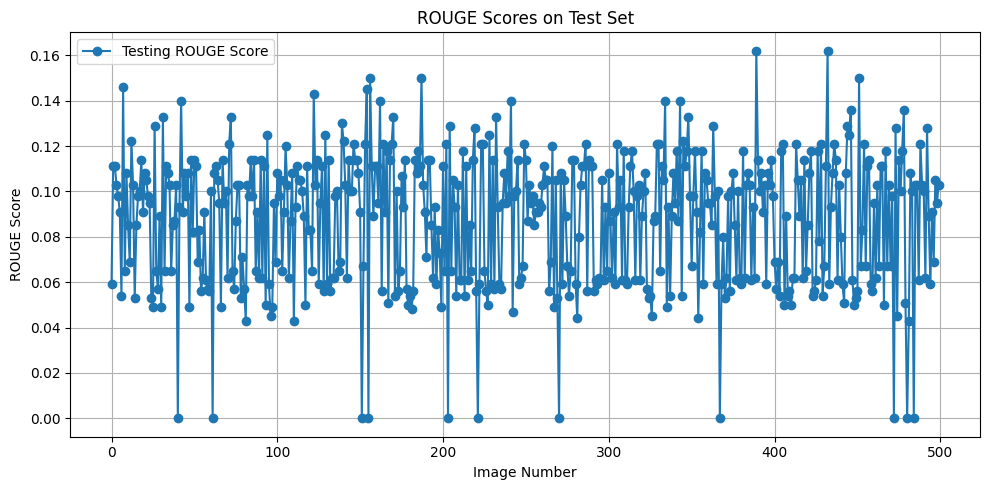

In [28]:
rouge_scores = [rouge_score_map[image][2] for image in rouge_score_map]
plt.figure(figsize=(10, 5))
plt.plot(rouge_scores, label='Testing ROUGE Score', marker='o')


plt.title('ROUGE Scores on Test Set')
plt.xlabel('Image Number')
plt.ylabel('ROUGE Score')


plt.legend()

plt.tight_layout()
plt.grid(True)
plt.show()

In [19]:
rouge_scores=[score_map[2] for score_map in rouge_score_map.values()]
print(f"Average Rouge Score for Test set : {sum(rouge_scores)/len(rouge_scores):.3f}")

Average Rouge Score for Test set : 0.088


In [23]:
def plot_top_frequent_words(caption_list,title,top_count=50):
    words=[]
    for caption in caption_list:
        caption_tokenized=[token.text.lower() for token in spacy_english.tokenizer(caption)]
        words.extend(caption_tokenized)
    total_freq=Counter(words)
    total_freq=total_freq.most_common(top_count)
    words, frequencies = zip(*total_freq)
    plt.figure(figsize=(12, 6))
    plt.bar(words, frequencies)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()



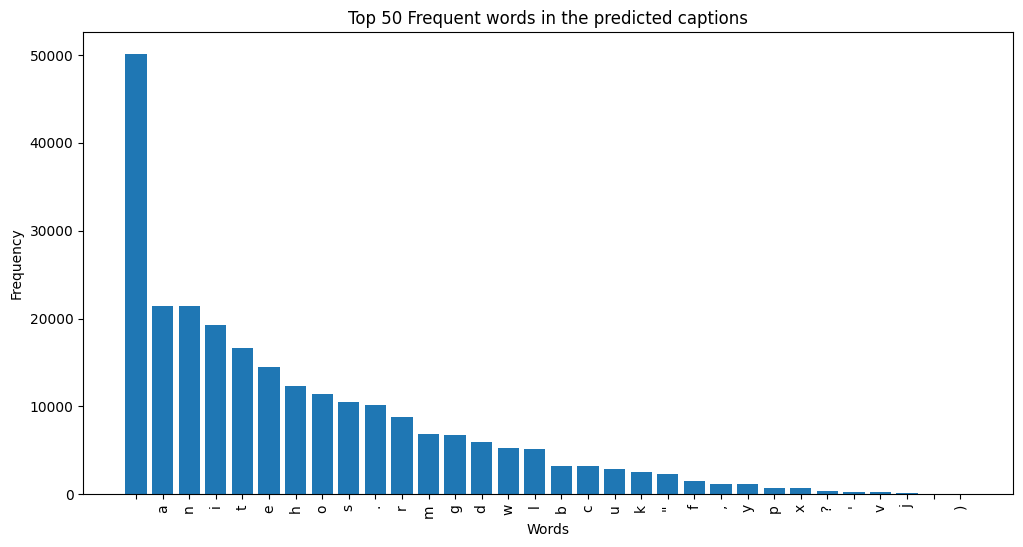

In [24]:
predicted_captions=[score_map[1] for score_map in rouge_score_map.values()]
prediction_title="Top 50 Frequent words in the predicted captions"
plot_top_frequent_words(predicted_captions,prediction_title)

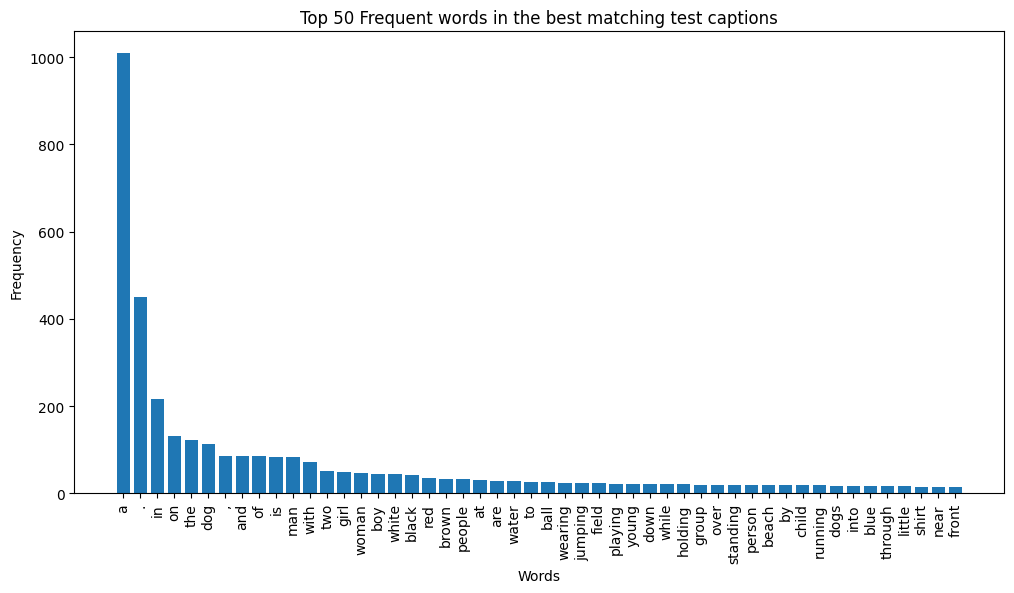

In [25]:
test_captions=[score_map[0] for score_map in rouge_score_map.values()]
test_title="Top 50 Frequent words in the best matching test captions"
plot_top_frequent_words(test_captions,test_title)